In [2]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, RegressorMixin

In [15]:
DD = []
for i in range(4):
    DD.append(pd.read_csv('data/s' + str(i+1) + '.csv'))
    
#Normalize so that range = [0,1]
for i in range(len(DD)):
    d = DD[i]
    d.iloc[:, 0] = (d.iloc[:, 0] - d.iloc[:, 0].min()) / (d.iloc[:, 0].max() - d.iloc[:, 0].min())
    d.iloc[:, 1] = (d.iloc[:, 1] - d.iloc[:, 1].min()) / (d.iloc[:, 1].max() - d.iloc[:, 1].min())

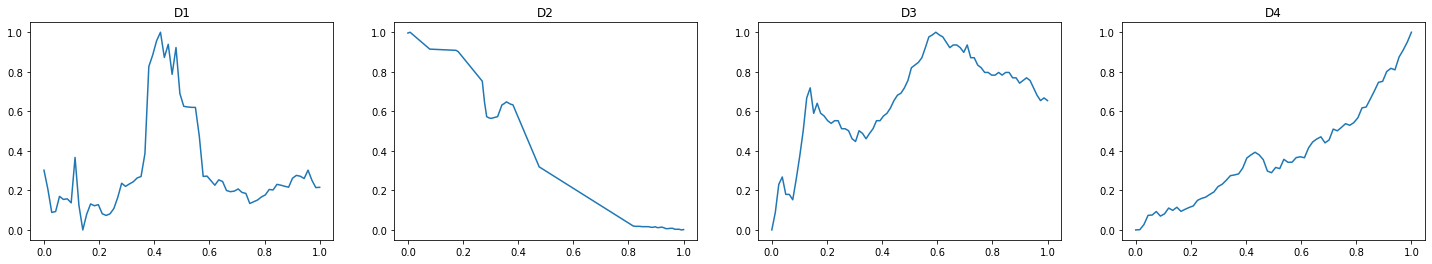

In [16]:
f = plt.figure()
f.set_figwidth(25)

for i in range(len(DD)):
    d = DD[i]
    dx = d.iloc[:, 0].to_numpy()
    dy = d.iloc[:, 1].to_numpy()
    plt.subplot(1, len(DD), (i+1))
    plt.title("D%s" % (i+1))
    plt.plot(dx,dy)

In [8]:
def H(x, y):
    return LinearRegression().fit(x, y)

def dist(dx, dy, model):
    dhy = model.predict(dx)
    return mean_squared_error(dy, dhy)

def T(x, y):
    minDist = math.inf
    minS = [[],[]]
    for i in range(len(x)):
        for j in range(len(x)):
            if i==j: continue
            sx = np.array([x[i], x[j]]).reshape(-1, 1)
            sy = np.array([y[i], y[j]])
            model = H(sx, sy)
            distance = dist(x, y, model)
            if (distance < minDist):
                minDist = distance
                minS[0] = sx
                minS[1] = sy
    return minS, minDist

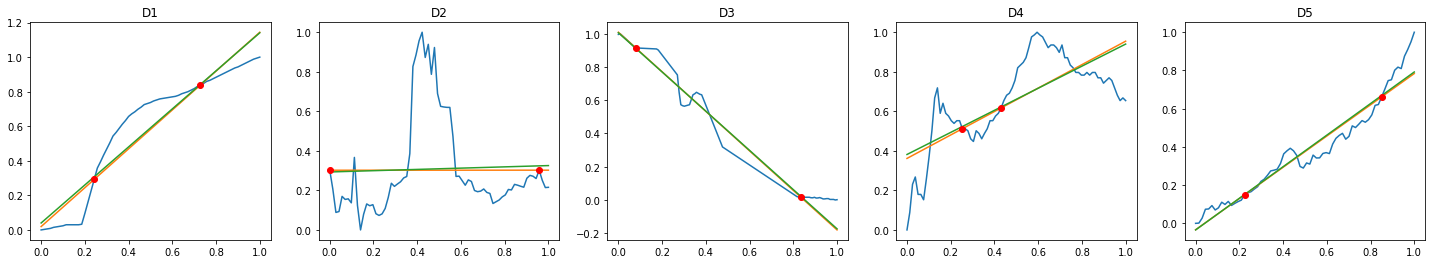

In [10]:
f = plt.figure()
f.set_figwidth(25)

for i in range(len(DD)):
    d = DD[i]
    dx = d.iloc[:, 0].to_numpy().reshape(-1, 1)
    dy = d.iloc[:, 1].to_numpy()
    
    s, distance = T(dx, dy)
    model = H(s[0], s[1])
    dhy = model.predict(dx)
    
    modelraw = H(dx, dy)
    rawdhy = modelraw.predict(dx)
    
    plt.subplot(1, len(DD), (i+1)) 
    plt.title("D%s" % (i+1))
    plt.plot(dx,dy)
    plt.plot(dx,dhy)
    plt.plot(dx,rawdhy)
    plt.plot(s[0], s[1], 'ro')

In [153]:
poly = PolynomialFeatures(degree=2, include_bias=True)

def Hquad(x, y):
    return LinearRegression().fit(poly.fit_transform(x), y)

def distquad(dx, dy, model):
    dhy = model.predict(poly.fit_transform(dx))
    return mean_squared_error(dy, dhy)

def Tquad(x, y):
    minDist = math.inf
    minS = [[],[]]
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            for k in range(j+1, len(x)):
                sx = np.array([x[i], x[j], x[k]]).reshape(-1, 1)
                sy = np.array([y[i], y[j], y[k]])
                model = Hquad(sx, sy)
                distance = distquad(x, y, model)
                if (distance < minDist):
                    minDist = distance
                    minS[0] = sx
                    minS[1] = sy
    return minS, minDist

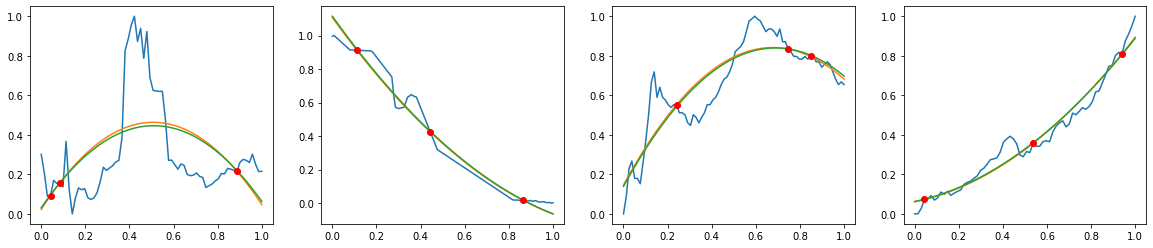

In [154]:
f = plt.figure()
f.set_figwidth(25)

for i in range(len(DD)):
    d = DD[i]
    dx = d.iloc[:, 0].to_numpy().reshape(-1, 1)
    dy = d.iloc[:, 1].to_numpy()
    
    s, distance = Tquad(dx, dy)
    model = Hquad(s[0], s[1])
    dhy = model.predict(poly.fit_transform(dx))
    
    modelraw = Hquad(dx, dy)
    rawdhy = modelraw.predict(poly.fit_transform(dx))
    
    plt.subplot(1, len(DD), (i+1)) 
    plt.plot(dx,dy)
    plt.plot(dx,dhy)
    plt.plot(dx,rawdhy)
    plt.plot(s[0], s[1], 'ro')

In [11]:
class PiecewiseLinearRegression(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        self.X = X
        self.y = y
        return self
    
    def predict(self, dX):
        dX = dX
        dy = np.zeros(len(dX))
        for i in range(len(dX)):
            dx = dX[i]
            x1 = 0
            x2 = 0
            k = len(self.X)
            for j in range(len(self.X)):
                if dx < self.X[j]:
                    k = j
                    break
            if k == 0:
                x1 = 0
                x2 = 1
            elif k == len(self.X):
                x1 = len(self.X) - 2
                x2 = len(self.X) - 1
            else:
                x1 = k - 1
                x2 = k
                
            dy[i] = self.y[x1] + (self.y[x2] - self.y[x1]) / (self.X[x2] - self.X[x1]) * (dx - self.X[x1])
           
        return dy


def H_PL(x, y):
    return PiecewiseLinearRegression().fit(x, y)

def dist_PL(dx, dy, model):
    dhy = model.predict(dx)
    return mean_squared_error(dy, dhy)

def T_PL(x, y, n, did):
    if n==2:
        return T(x, y)
    minDist = math.inf
    minx0 = -1
    minx1 = -1
    recnp = np.load("storage/recnp%s.npy" % (did)) #load from disk
    recdist = np.load("storage/recdist%s.npy" % (did)) #load from disk
#     recnp = np.ones([len(x), len(x)]) * -1
#     recdist = np.ones([len(x), len(x)]) * -1
    if recnp[prevx][n] != -1:
        return recnp[prevx][n], recdist[prevx][n]
    
    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            xcut = x[0:(j+1)]
            ycut = y[0:(j+1)]
            sx = np.array([x[i], x[j]])
            sy = np.array([y[i], y[j]])
            model = LinearRegression().fit(sx, sy)
            distance = dist(xcut, ycut, model)
            fx, fdist = T_PLRecursion(x, y, j, n-2, recnp, recdist)
            distance += fdist
            if distance < minDist:
                minDist = distance
                minx0 = i
                minx1 = j
    
    minSx = [x[minx0], x[minx1]]
    minSy = [y[minx0], y[minx1]]
    k = minx1
    for i in range(n-2):
        k = int(recnp[k][n-2-i])
        minSx.append(x[k])
        minSy.append(y[k])
    
    np.save("storage/recnp%s.npy" % (did),recnp) # save to disk
    np.save("storage/recdist%s.npy" % (did), recdist) # save to disk
    return [minSx, minSy], minDist

# returns array of size n, containing indexes of x that results in min distance 
def T_PLRecursion(x, y, prevx, n, recnp, recdist):
    if n == 0: return -1, 0
    if recnp[prevx][n] != -1:
        return recnp[prevx][n], recdist[prevx][n]
    minDist = math.inf
    minSx = 0
    xcut, ycut = [], []
    for i in range(prevx + 1, len(x)):
        if n == 1:
            xcut = x[prevx+1:len(x)]
            ycut = y[prevx+1:len(x)]
        else:
            xcut = x[prevx+1:(i+1)]
            ycut = y[prevx+1:(i+1)]
        sx = [x[prevx], x[i]]
        sy = [y[prevx], y[i]]
        model = LinearRegression().fit(sx, sy)
        distance = dist(xcut, ycut, model)
        fx, fdist = T_PLRecursion(x, y, i, n-1, recnp, recdist)
        distance += fdist
        if distance < minDist:
            minDist = distance
            minSx = i
    
    recdist[prevx][n] = minDist
    recnp[prevx][n] = minSx  
    return minSx, minDist

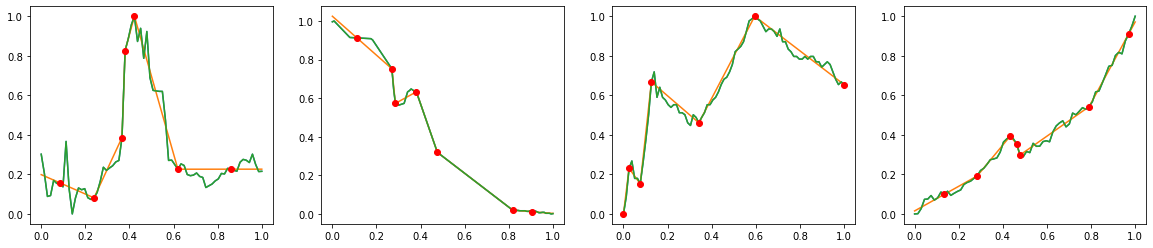

In [17]:
f = plt.figure()
f.set_figwidth(20)

errors = []

for i in range(4):
    d = DD[i]
    dx = d.iloc[:, 0].to_numpy()
    dy = d.iloc[:, 1].to_numpy()
    
    mindist = math.inf
    mins = []
    for j in range(2, 8):
        s, distance = T_PL(dx.reshape(-1, 1), dy, j, i)
#         distance += 0.001*j #regularization
        if distance < mindist:
            mindist = distance
            mins = s
            
    model = H_PL(mins[0], mins[1])
    dhy = model.predict(dx)
    
    modelraw = H_PL(dx, dy)
    rawdhy = modelraw.predict(dx)
    
    plt.subplot(1, len(DD), (i+1)) 
    plt.plot(dx,dy)
    plt.plot(dx,dhy)
    plt.plot(dx,rawdhy)
    plt.plot(mins[0], mins[1], 'ro')

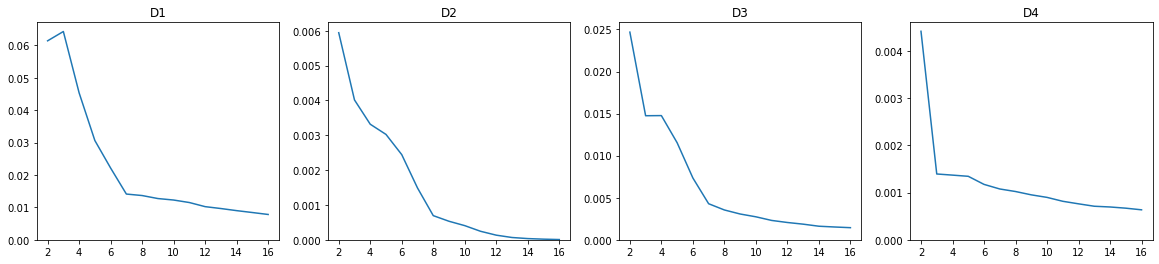

In [157]:
f = plt.figure()
f.set_figwidth(20)

start = 2
end = 16
for i in range(len(DD)):
    d = DD[i]
    dx = d.iloc[:, 0].to_numpy()
    dy = d.iloc[:, 1].to_numpy()
    errx = np.arange(start, end+1)
    erry = np.zeros(len(errx))
    for n in errx:
        s, distance = T_PL(dx.reshape(-1, 1), dy, n, i)
        erry[n-start] = distance + 0.001

#     modelraw = H_PL(dx, dy)
#     rawdist = dist_PL(dx, dy, modelraw)
#     rawdistx = np.array([start, end])
#     rawdisty = np.array([rawdist, rawdist]
#     for n in errx:
    plt.subplot(1, len(DD), (i+1)) 
    plt.title("D%s" % (i+1))
    plt.plot(errx,erry)
    plt.gca().set_ylim(bottom=0)
    
    np.save("erry%s.npy" % (i), erry) # save to disk
#     plt.plot(rawdistx, rawdisty)

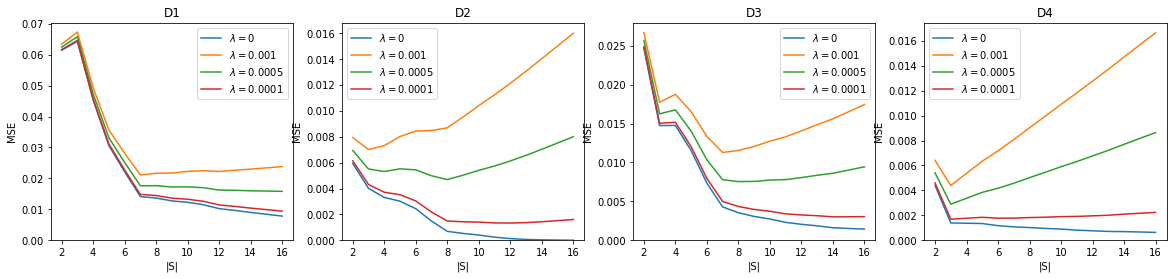

In [171]:
f = plt.figure()
f.set_figwidth(20)
rps = [0.001, 0.0005, 0.0001]
for i in range(len(DD)):
    errx = np.arange(start, end+1)
    erry = np.load("erry%s.npy" % (i))
    errys = []
    for rp in rps:
        err = erry.copy()
        for j in range(len(errx)):
            err[j] += rp * errx[j]
        errys.append(err)
   
    plt.subplot(1, len(DD), (i+1)) 
    plt.title("D%s" % (i+1))
    plt.xlabel("|S|")
    plt.ylabel("MSE")
    plt.plot(errx, erry, label=r'$\lambda = 0$')
    for j in range(len(rps)):
        plt.plot(errx,errys[j], label=r'$\lambda = %s$' % rps[j])
    plt.gca().set_ylim(bottom=0)
    plt.legend()

# 